In [1]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

# Load your dataset (replace with your dataset path)
dataset_path = "C:/Users/vsing/OneDrive/Desktop/Capstone Project/Capstone_project_Sentiment_Analysis_Aspect_Level/Datasets/Capstone Project Dataset- Restaurent Train 1 category.xlsx"
df = pd.read_excel(dataset_path)


# Display the first few rows of the dataset
print(df.head())


C:\Users\Charu\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   S No.                                           Sentence     Category_A  \
0      1               But the staff was so horrible to us.        service   
1      2  To be completely fair, the only redeeming fact...           food   
2      3  The food is uniformly exceptional, with a very...           food   
3      4  Where Gabriela personaly greets you and recomm...        service   
4      5  For those that go once and don't enjoy it, all...  miscellaneous   

  Polarity_A  
0   negative  
1   positive  
2   positive  
3   positive  
4   positive  


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

# Define a tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define a function to preprocess text and convert labels
def preprocess_text(text):
    # You can add text preprocessing steps here, e.g., lowercasing
    return text.lower()

def convert_labels(category, polarity):
    # Map category to numerical values
    categories = ['food', 'service', 'ambience', 'polarity', 'miscellaneous']
    category_id = categories.index(category)
    
    # Map polarity to numerical values
    polarities = ['positive', 'negative', 'neutral']
    polarity_id = polarities.index(polarity)
    
    return category_id, polarity_id


# Define a custom PyTorch Dataset
class RestaurantReviewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row['Sentence']
        category, polarity = convert_labels(row['Category_A'], row['Polarity_A'])

        # Preprocess text
        text = preprocess_text(text)

        # Tokenize text
        inputs = self.tokenizer(text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt')

        # Convert to PyTorch tensors
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'category': category,
            'polarity': polarity
        }

# Create train and validation datasets
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = RestaurantReviewsDataset(train_df, tokenizer)
val_dataset = RestaurantReviewsDataset(val_df, tokenizer)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [3]:
import torch
from transformers import BertModel, BertTokenizer
import torch.nn as nn

# Define the BERT model and tokenizer
bert_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert = BertModel.from_pretrained(bert_model_name)

class RestaurantReviewsModel(nn.Module):
    def __init__(self, bert, num_categories, num_polarities):
        super(RestaurantReviewsModel, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.category_classifier = nn.Linear(bert.config.hidden_size, num_categories)
        self.polarity_classifier = nn.Linear(bert.config.hidden_size, num_polarities)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        category_logits = self.category_classifier(pooled_output)
        polarity_logits = self.polarity_classifier(pooled_output)
        return category_logits, polarity_logits

# Create the model
num_categories = 5  # Number of categories: food, service, ambience, polarity, miscellaneous
num_polarities = 3  # Number of polarities: positive, negative, neutral
model = RestaurantReviewsModel(bert, num_categories, num_polarities)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch

# Preprocess the dataset
le_category = LabelEncoder()
le_polarity = LabelEncoder()

# Encode category and polarity columns
df['Category_A'] = le_category.fit_transform(df['Category_A'])
df['Polarity_A'] = le_polarity.fit_transform(df['Polarity_A'])

# Split the dataset into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Define a function to tokenize and preprocess the text
def preprocess_text(text, tokenizer, max_length):
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
    return inputs

max_text_length = 128  # Define your desired maximum text length

# Tokenize and preprocess the text data
train_texts = train_df['Sentence'].values
val_texts = val_df['Sentence'].values

train_inputs = [preprocess_text(text, tokenizer, max_text_length) for text in train_texts]
val_inputs = [preprocess_text(text, tokenizer, max_text_length) for text in val_texts]

# Prepare input tensors
train_input_ids = torch.cat([inputs['input_ids'] for inputs in train_inputs], dim=0)
train_attention_mask = torch.cat([inputs['attention_mask'] for inputs in train_inputs], dim=0)
train_token_type_ids = torch.cat([inputs['token_type_ids'] for inputs in train_inputs], dim=0)

val_input_ids = torch.cat([inputs['input_ids'] for inputs in val_inputs], dim=0)
val_attention_mask = torch.cat([inputs['attention_mask'] for inputs in val_inputs], dim=0)
val_token_type_ids = torch.cat([inputs['token_type_ids'] for inputs in val_inputs], dim=0)

# Convert labels to tensors with Long data type
train_categories = torch.tensor(train_df['Category_A'].values, dtype=torch.long)
train_polarities = torch.tensor(train_df['Polarity_A'].values, dtype=torch.long)

val_categories = torch.tensor(val_df['Category_A'].values, dtype=torch.long)
val_polarities = torch.tensor(val_df['Polarity_A'].values, dtype=torch.long)


# Create DataLoader for training and validation
batch_size = 32  # Define your desired batch size
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_token_type_ids, train_categories, train_polarities)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_token_type_ids, val_categories, val_polarities)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define your optimizer and loss function
import torch.optim as optim
import torch.nn as nn

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
category_criterion = nn.CrossEntropyLoss()
polarity_criterion = nn.CrossEntropyLoss()

In [5]:
# Training loop
num_epochs = 5  # Define your desired number of training epochs

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    correct_train_predictions = 0
    total_train_samples = 0
    
    for batch in train_loader:
        input_ids, attention_mask, token_type_ids, categories, polarities = batch
        
        optimizer.zero_grad()
        category_logits, polarity_logits = model(input_ids, attention_mask, token_type_ids)
        
        category_loss = category_criterion(category_logits, categories)
        polarity_loss = polarity_criterion(polarity_logits, polarities)
        
        loss = category_loss + polarity_loss
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        _, category_preds = category_logits.max(dim=1)
        _, polarity_preds = polarity_logits.max(dim=1)
        
        correct_train_predictions += (category_preds == categories).sum().item() + (polarity_preds == polarities).sum().item()
        total_train_samples += categories.size(0)
    
    train_accuracy = correct_train_predictions / total_train_samples

    model.eval()
    val_losses = []
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, token_type_ids, categories, polarities = batch
            category_logits, polarity_logits = model(input_ids, attention_mask, token_type_ids)
            
            category_loss = category_criterion(category_logits, categories)
            polarity_loss = polarity_criterion(polarity_logits, polarities)
            
            loss = category_loss + polarity_loss
            val_losses.append(loss.item())
            
            _, category_preds = category_logits.max(dim=1)
            _, polarity_preds = polarity_logits.max(dim=1)
            
            correct_val_predictions += (category_preds == categories).sum().item() + (polarity_preds == polarities).sum().item()
            total_val_samples += categories.size(0)
    
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    
    val_accuracy = correct_val_predictions / total_val_samples

    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')



Epoch 1/5: Train Loss: 2.1261, Val Loss: 1.7150, Train Acc: 1.1212, Val Acc: 1.3171
Epoch 2/5: Train Loss: 1.4292, Val Loss: 1.1112, Train Acc: 1.5024, Val Acc: 1.6554
Epoch 3/5: Train Loss: 0.8916, Val Loss: 0.8507, Train Acc: 1.7247, Val Acc: 1.7230
Epoch 4/5: Train Loss: 0.5543, Val Loss: 0.8117, Train Acc: 1.8428, Val Acc: 1.7188
Epoch 5/5: Train Loss: 0.3464, Val Loss: 0.7650, Train Acc: 1.9137, Val Acc: 1.7548


In [6]:
# Save the RestaurantReviewsModel's state_dict to a file
torch.save(model.state_dict(), 'restaurant_reviews_model.pth')


In [7]:


# Define the BERT model and tokenizer
bert_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert = BertModel.from_pretrained(bert_model_name)

# Create an instance of your model
model = RestaurantReviewsModel(bert, num_categories, num_polarities)

# Load the state_dict from the saved file
model.load_state_dict(torch.load('restaurant_reviews_model.pth'))



<All keys matched successfully>

In [8]:
label_encoder_save_path = "label_encoders.pkl"  # Replace with your desired label encoders file path
import joblib
joblib.dump(le_category, label_encoder_save_path + "_category")
joblib.dump(le_polarity, label_encoder_save_path + "_polarity")



['label_encoders.pkl_polarity']

In [9]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import joblib
import numpy as np

# Load the saved model
from restaurant_model import RestaurantReviewsModel  # Make sure to use the correct import statement

# Load the label encoders
le_category = joblib.load("label_encoders.pkl_category")
le_polarity = joblib.load("label_encoders.pkl_polarity")

# Specify the file path to your test data Excel file
test_file_path = "C:/Users/Charu/Desktop/charu try/dataset/Capstone Project Dataset- Restaurent Test one category.xlsx"

# Load test data from the Excel file
test_df = pd.read_excel(test_file_path)

# Preprocess the test data
test_texts = test_df['Sentence'].values

# Encode "Category_A" and "Polarity_A" columns using the loaded label encoders
test_df['Category_A'] = le_category.transform(test_df['Category_A'])
test_df['Polarity_A'] = le_polarity.transform(test_df['Polarity_A'])

# Tokenize and preprocess the test data
test_inputs = [preprocess_text(text, tokenizer, max_text_length) for text in test_texts]

# Prepare input tensors for the test data
test_input_ids = torch.cat([inputs['input_ids'] for inputs in test_inputs], dim=0)
test_attention_mask = torch.cat([inputs['attention_mask'] for inputs in test_inputs], dim=0)
test_token_type_ids = torch.cat([inputs['token_type_ids'] for inputs in test_inputs], dim=0)

# Convert labels to tensors with Long data type for the test data
test_categories = torch.tensor(test_df['Category_A'].values, dtype=torch.long)
test_polarities = torch.tensor(test_df['Polarity_A'].values, dtype=torch.long)

# Create DataLoader for testing
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_token_type_ids, test_categories, test_polarities)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model on the test data
def evaluate(model, data_loader):
    model.eval()
    test_losses = []
    category_correct = 0
    polarity_correct = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, token_type_ids, categories, polarities = batch
            category_logits, polarity_logits = model(input_ids, attention_mask, token_type_ids)
            
            category_loss = category_criterion(category_logits, categories)
            polarity_loss = polarity_criterion(polarity_logits, polarities)
            
            test_losses.append(category_loss.item() + polarity_loss.item())

            # Calculate category accuracy
            category_preds = torch.argmax(category_logits, dim=1)
            category_correct += (category_preds == categories).sum().item()
            
            # Calculate polarity accuracy
            polarity_preds = torch.argmax(polarity_logits, dim=1)
            polarity_correct += (polarity_preds == polarities).sum().item()
    
    test_loss = np.mean(test_losses)
    category_accuracy = category_correct / len(data_loader.dataset)
    polarity_accuracy = polarity_correct / len(data_loader.dataset)
    
    return test_loss, category_accuracy, polarity_accuracy

# Load the saved model
loaded_model = RestaurantReviewsModel(bert, num_categories, num_polarities)
loaded_model.load_state_dict(torch.load('restaurant_reviews_model.pth'))

# Evaluate the loaded model on the test data
test_loss, test_category_accuracy, test_polarity_accuracy = evaluate(loaded_model, test_loader)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Category Accuracy: {test_category_accuracy*100:.2f}%')
print(f'Test Polarity Accuracy: {test_polarity_accuracy*100:.2f}%')


Test Loss: 1.2534
Test Category Accuracy: 85.98%
Test Polarity Accuracy: 77.60%


In [10]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import joblib
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load the saved model
from restaurant_model import RestaurantReviewsModel  # Make sure to use the correct import statement

# Load the test data from the Excel file
test_file_path = "C:/Users/Charu/Desktop/charu try/dataset/Capstone Project Dataset- Restaurent Test one category.xlsx"
test_df = pd.read_excel(test_file_path)

# Preprocess the test data
test_texts = test_df['Sentence'].values

# Load the label encoders
le_category = LabelEncoder()
le_polarity = LabelEncoder()

# Specify the labels you expect in your predictions
expected_category_labels = ["ambience", "food", "miscellaneous", "price", "service"]
expected_polarity_labels = ["negative", "neutral", "positive"]

# Fit the label encoders with the expected labels
le_category.fit(expected_category_labels)
le_polarity.fit(expected_polarity_labels)

# Tokenize and preprocess the test data
test_inputs = [preprocess_text(text, tokenizer, max_text_length) for text in test_texts]

# Prepare input tensors for the test data
test_input_ids = torch.cat([inputs['input_ids'] for inputs in test_inputs], dim=0)
test_attention_mask = torch.cat([inputs['attention_mask'] for inputs in test_inputs], dim=0)
test_token_type_ids = torch.cat([inputs['token_type_ids'] for inputs in test_inputs], dim=0)

# Create DataLoader for testing
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_token_type_ids)
batch_size = 32  # Specify your desired batch size
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model on the test data
def evaluate(model, data_loader):
    model.eval()
    predicted_categories = []
    predicted_polarities = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, token_type_ids = batch
            category_logits, polarity_logits = model(input_ids, attention_mask, token_type_ids)

            # Decode the predicted category and polarity labels
            category_preds = le_category.inverse_transform(torch.argmax(category_logits, dim=1).numpy())
            polarity_preds = le_polarity.inverse_transform(torch.argmax(polarity_logits, dim=1).numpy())

            predicted_categories.extend(category_preds)
            predicted_polarities.extend(polarity_preds)

    return predicted_categories, predicted_polarities

# Load the saved model
loaded_model = RestaurantReviewsModel(bert, num_categories, num_polarities)
loaded_model.load_state_dict(torch.load('restaurant_reviews_model.pth'))

# Evaluate the loaded model on the test data
predicted_categories, predicted_polarities = evaluate(loaded_model, test_loader)

# Add the predicted category and polarity to the test_df DataFrame
test_df['Predicted_Category'] = predicted_categories
test_df['Predicted_Polarity'] = predicted_polarities

# Specify the path to save the Excel file with predictions
output_file_path = "path_to_save_predictions.xlsx"

# Save the DataFrame with the additional columns
test_df.to_excel(output_file_path, index=False)

# Print a message indicating the Excel file has been saved
print(f"Predictions saved to {output_file_path}")


Predictions saved to path_to_save_predictions.xlsx


In [17]:
import pandas as pd
from sklearn.metrics import classification_report

# Load the data from the Excel file
result_df = pd.read_excel("path_to_save_predictions.xlsx")

# Define the aspect and sentiment categories
aspect_labels = ["food", "ambience", "service", "price", "miscellaneous"]
sentiment_labels = ["positive", "neutral", "negative"]

# Aspect classification report
aspect_report = classification_report(result_df["Category_A"], result_df["Predicted_Category"], labels=aspect_labels)

# Sentiment classification report
sentiment_report = classification_report(result_df["Polarity_A"], result_df["Predicted_Polarity"], labels=sentiment_labels)

print("Aspect Classification Report:")
print(aspect_report)

print("\nSentiment Classification Report:")
print(sentiment_report)


Aspect Classification Report:
               precision    recall  f1-score   support

         food       0.87      0.94      0.90       367
     ambience       0.86      0.67      0.75        84
      service       0.80      0.78      0.79       120
        price       0.77      0.61      0.68        33
miscellaneous       0.89      0.88      0.89       195

     accuracy                           0.86       799
    macro avg       0.84      0.78      0.80       799
 weighted avg       0.86      0.86      0.86       799


Sentiment Classification Report:
              precision    recall  f1-score   support

    positive       0.89      0.85      0.87       566
     neutral       0.16      0.25      0.19        40
    negative       0.66      0.67      0.67       193

    accuracy                           0.78       799
   macro avg       0.57      0.59      0.58       799
weighted avg       0.80      0.78      0.79       799



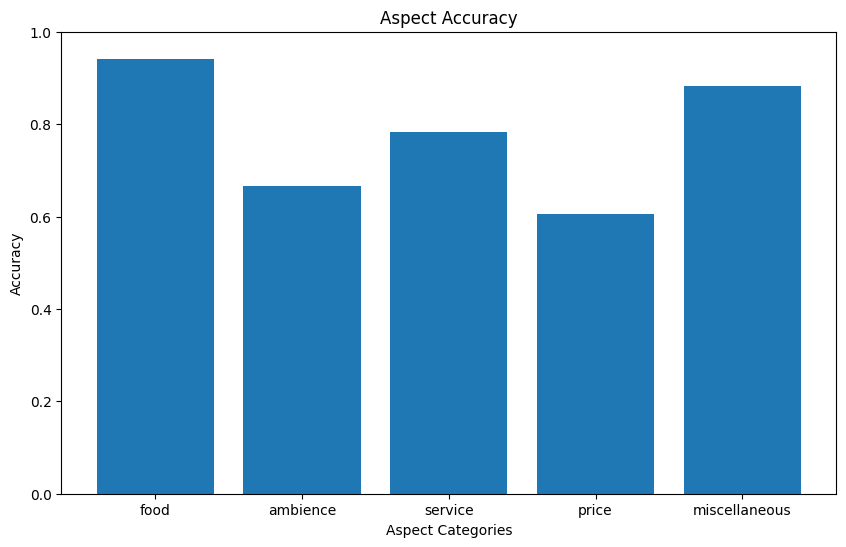

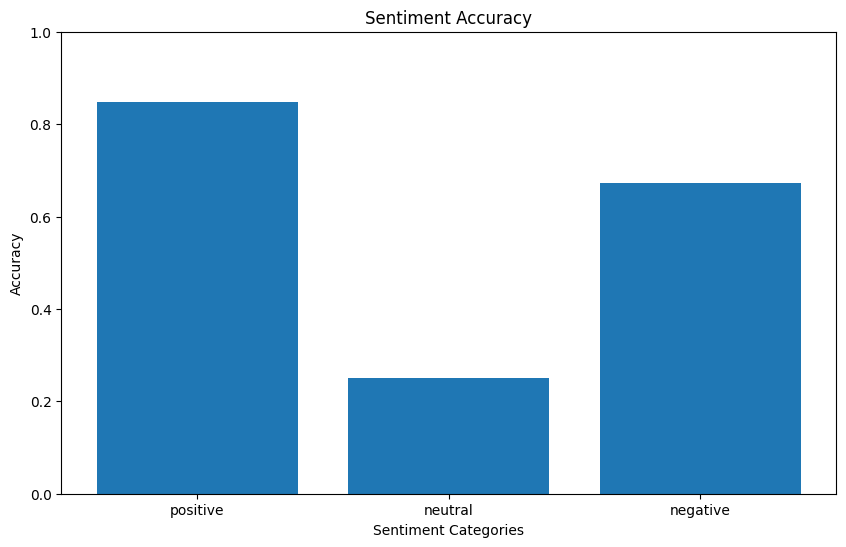

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the Excel file
result_df = pd.read_excel("path_to_save_predictions.xlsx")

# Define the aspect and sentiment categories
aspect_labels = ["food", "ambience", "service", "price", "miscellaneous"]
sentiment_labels = ["positive", "neutral", "negative"]

# Initialize dictionaries to store aspect and sentiment accuracy
aspect_accuracy = {}
sentiment_accuracy = {}

# Calculate aspect and sentiment accuracy
for aspect in aspect_labels:
    correct_aspect = result_df[result_df["Category_A"] == aspect]
    correct_aspect_count = len(correct_aspect)
    correct_aspect_predicted = correct_aspect[correct_aspect["Predicted_Category"] == aspect]
    correct_aspect_predicted_count = len(correct_aspect_predicted)
    
    aspect_accuracy[aspect] = correct_aspect_predicted_count / correct_aspect_count if correct_aspect_count > 0 else 0

for sentiment in sentiment_labels:
    correct_sentiment = result_df[result_df["Polarity_A"] == sentiment]
    correct_sentiment_count = len(correct_sentiment)
    correct_sentiment_predicted = correct_sentiment[correct_sentiment["Predicted_Polarity"] == sentiment]
    correct_sentiment_predicted_count = len(correct_sentiment_predicted)
    
    sentiment_accuracy[sentiment] = correct_sentiment_predicted_count / correct_sentiment_count if correct_sentiment_count > 0 else 0

# Create Aspect Accuracy Plot
plt.figure(figsize=(10, 6))
plt.bar(aspect_accuracy.keys(), aspect_accuracy.values())
plt.xlabel("Aspect Categories")
plt.ylabel("Accuracy")
plt.title("Aspect Accuracy")
plt.ylim(0, 1)
plt.show()

# Create Sentiment Accuracy Plot
plt.figure(figsize=(10, 6))
plt.bar(sentiment_accuracy.keys(), sentiment_accuracy.values())
plt.xlabel("Sentiment Categories")
plt.ylabel("Accuracy")
plt.title("Sentiment Accuracy")
plt.ylim(0, 1)
plt.show()


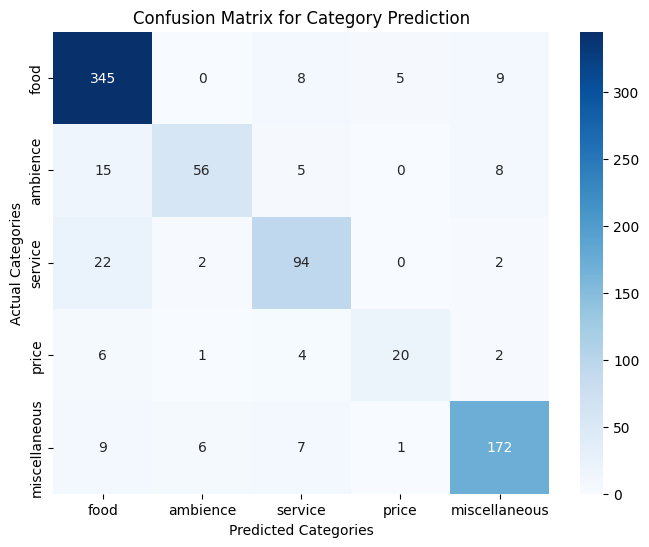

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the Excel file
result_df = pd.read_excel("path_to_save_predictions.xlsx")

# Assuming you have columns 'Category_A' and 'Predicted_Category' in your DataFrame
actual_categories = result_df['Category_A'].tolist()
predicted_categories = result_df['Predicted_Category'].tolist()

# Define the list of category labels
category_labels = ['food', 'ambience', 'service', 'price', 'miscellaneous']

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(actual_categories, predicted_categories, labels=category_labels)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues', xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel('Predicted Categories')
plt.ylabel('Actual Categories')
plt.title('Confusion Matrix for Category Prediction')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the Excel file
result_df = pd.read_excel("path_to_save_predictions.xlsx")

# Assuming you have columns 'Category_A' and 'Predicted_Category' in your DataFrame
actual_categories = result_df['Category_A'].tolist()
predicted_categories = result_df['Predicted_Category'].tolist()

# Define the list of category labels
category_labels = ['food', 'ambience', 'service', 'price', 'miscellaneous']

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(actual_categories, predicted_categories, labels=category_labels)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))

# Create a list to store the labels
cell_labels = []

for i in range(len(category_labels)):
    for j in range(len(category_labels)):
        cell_labels.append(f"TP: {confusion_matrix_result[i, i]}\nTN: {np.sum(confusion_matrix_result) - np.sum(confusion_matrix_result[i, :]) - np.sum(confusion_matrix_result[:, i]) + confusion_matrix_result[i, i]}\nFP: {np.sum(confusion_matrix_result[:, i]) - confusion_matrix_result[i, i]}\nFN: {np.sum(confusion_matrix_result[i, :]) - confusion_matrix_result[i, i]}")

# Create a heatmap and add labels to each cell
sns.heatmap(confusion_matrix_result, annot=np.array(cell_labels).reshape(5, 5), fmt='', cmap='Blues', xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel('Predicted Categories')
plt.ylabel('Actual Categories')
plt.title('Confusion Matrix for Category Prediction')
plt.show()


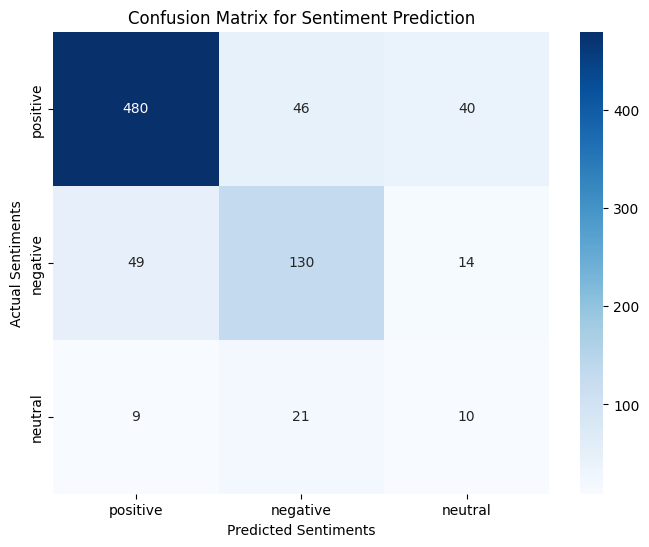

In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the Excel file
result_df = pd.read_excel("path_to_save_predictions.xlsx")

# Assuming you have columns 'Polarity_A' and 'Predicted_Polarity' in your DataFrame
actual_sentiments = result_df['Polarity_A'].tolist()
predicted_sentiments = result_df['Predicted_Polarity'].tolist()

# Define the list of sentiment labels
sentiment_labels = ['positive', 'negative', 'neutral']

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(actual_sentiments, predicted_sentiments, labels=sentiment_labels)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.xlabel('Predicted Sentiments')
plt.ylabel('Actual Sentiments')
plt.title('Confusion Matrix for Sentiment Prediction')
plt.show()


<module 'matplotlib.pyplot' from 'C:\\Users\\Charu\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\pyplot.py'>

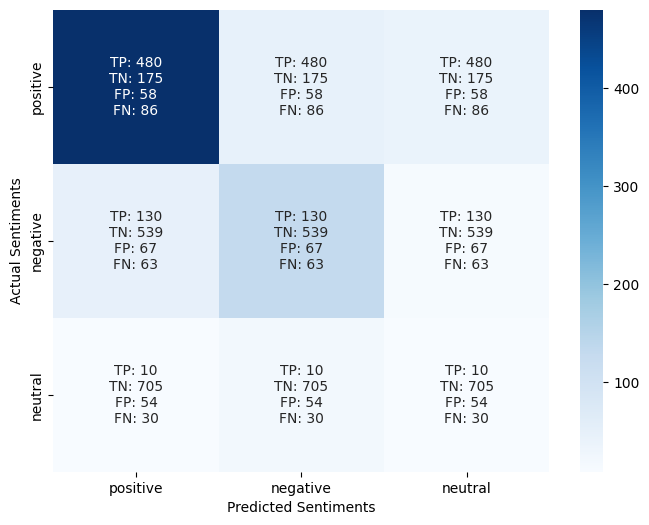

In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the Excel file
result_df = pd.read_excel("path_to_save_predictions.xlsx")

# Assuming you have columns 'Polarity_A' and 'Predicted_Polarity' in your DataFrame
actual_sentiments = result_df['Polarity_A'].tolist()
predicted_sentiments = result_df['Predicted_Polarity'].tolist()

# Define the list of sentiment labels
sentiment_labels = ['positive', 'negative', 'neutral']

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(actual_sentiments, predicted_sentiments, labels=sentiment_labels)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))

# Create a list to store the labels
cell_labels = []

for i in range(len(sentiment_labels)):
    for j in range(len(sentiment_labels)):
        cell_labels.append(f"TP: {confusion_matrix_result[i, i]}\nTN: {np.sum(confusion_matrix_result) - np.sum(confusion_matrix_result[i, :]) - np.sum(confusion_matrix_result[:, i]) + confusion_matrix_result[i, i]}\nFP: {np.sum(confusion_matrix_result[:, i]) - confusion_matrix_result[i, i]}\nFN: {np.sum(confusion_matrix_result[i, :]) - confusion_matrix_result[i, i]}")

# Create a heatmap and add labels to each cell
sns.heatmap(confusion_matrix_result, annot=np.array(cell_labels).reshape(3, 3), fmt='', cmap='Blues', xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.xlabel('Predicted Sentiments')
plt.ylabel('Actual Sentiments')
plt



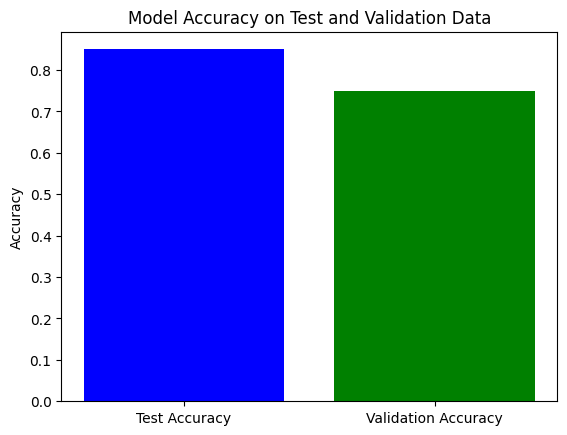

In [23]:
import matplotlib.pyplot as plt

# Assuming you have stored the accuracies in the following variables
test_accuracy = 0.85  # Replace with the actual test accuracy
validation_accuracy = 0.75  # Replace with the actual validation accuracy

# Create labels for the bars
labels = ['Test Accuracy', 'Validation Accuracy']

# Create a list of accuracy values
accuracies = [test_accuracy, validation_accuracy]

# Create a bar plot
plt.bar(labels, accuracies, color=['blue', 'green'])

# Add titles and labels
plt.title('Model Accuracy on Test and Validation Data')
plt.ylabel('Accuracy')

# Show the plot
plt.show()


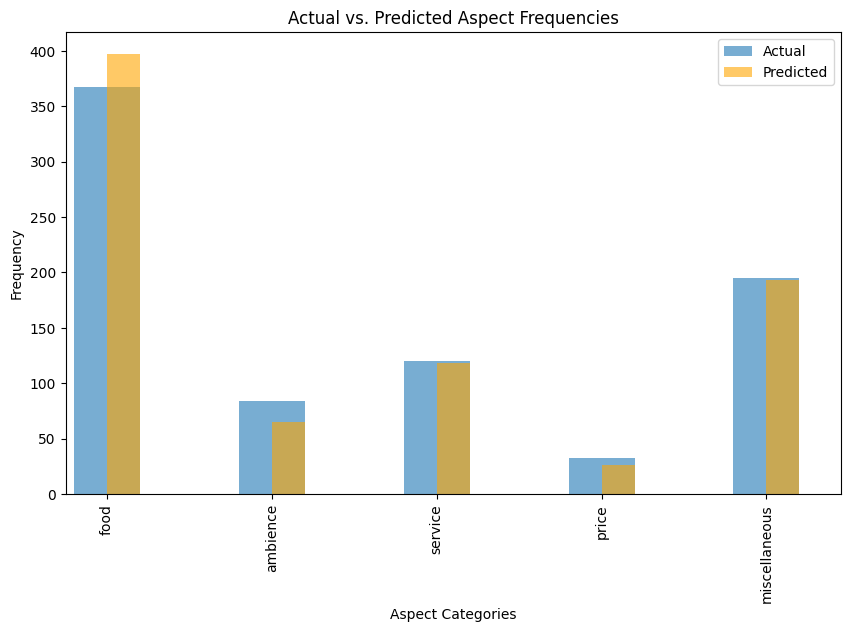

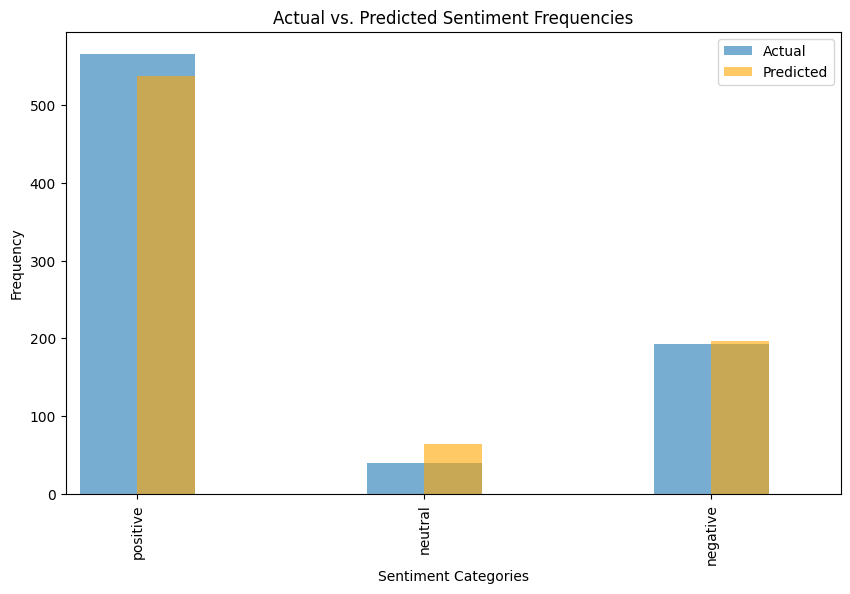

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the Excel file
result_df = pd.read_excel("path_to_save_predictions.xlsx")

# Define the aspect and sentiment categories
aspect_labels = ["food", "ambience", "service", "price", "miscellaneous"]
sentiment_labels = ["positive", "neutral", "negative"]

# Create a bar chart for actual and predicted aspects
plt.figure(figsize=(10, 6))
actual_aspect_counts = result_df["Category_A"].value_counts().reindex(aspect_labels, fill_value=0)
predicted_aspect_counts = result_df["Predicted_Category"].value_counts().reindex(aspect_labels, fill_value=0)
actual_aspect_counts.plot(kind="bar", width=0.4, label="Actual", align="center", alpha=0.6)
predicted_aspect_counts.plot(kind="bar", width=0.2, label="Predicted", align="edge", alpha=0.6, color="orange")  # Change the color to orange
plt.xlabel("Aspect Categories")
plt.ylabel("Frequency")
plt.title("Actual vs. Predicted Aspect Frequencies")
plt.legend()
plt.show()

# Create a bar chart for actual and predicted sentiments
plt.figure(figsize=(10, 6))
actual_sentiment_counts = result_df["Polarity_A"].value_counts().reindex(sentiment_labels, fill_value=0)
predicted_sentiment_counts = result_df["Predicted_Polarity"].value_counts().reindex(sentiment_labels, fill_value=0)
actual_sentiment_counts.plot(kind="bar", width=0.4, label="Actual", align="center", alpha=0.6)
predicted_sentiment_counts.plot(kind="bar", width=0.2, label="Predicted", align="edge", alpha=0.6, color="orange")  # Change the color to orange
plt.xlabel("Sentiment Categories")
plt.ylabel("Frequency")
plt.title("Actual vs. Predicted Sentiment Frequencies")
plt.legend()
plt.show()


saved model loaded then predicted on unseen sentences


In [13]:
import torch
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder

# Load the saved model
model_path = 'restaurant_reviews_model.pth'  # Replace with the path to your saved model
model = RestaurantReviewsModel(bert, num_categories, num_polarities)  # Create an instance of your model
model.load_state_dict(torch.load(model_path))
model.eval()

# Load the saved label encoders
label_encoder_save_path = "label_encoders.pkl"  # Replace with the path to your saved label encoders
le_category = joblib.load(label_encoder_save_path + "_category")
le_polarity = joblib.load(label_encoder_save_path + "_polarity")

# Define your tokenizer and maximum text length
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_text_length = 128  # Define your desired maximum text length

# Define the unseen sentences
unseen_sentences = [
    "The food was really good.",
    "The service was great.",
    "The ambience of the restaurant is pleasant.",
    "I absolutely love this restaurant; everything about it is perfect.",
    "My experience at this restaurant was neither exceptional nor terrible.",
    "The restaurant occasionally has special discounts, which is a plus."
]


# Preprocess the unseen sentences and tokenize them
unseen_inputs = [preprocess_text(text, tokenizer, max_text_length) for text in unseen_sentences]

# Prepare input tensors for the unseen data
unseen_input_ids = torch.cat([inputs['input_ids'] for inputs in unseen_inputs], dim=0)
unseen_attention_mask = torch.cat([inputs['attention_mask'] for inputs in unseen_inputs], dim=0)
unseen_token_type_ids = torch.cat([inputs['token_type_ids'] for inputs in unseen_inputs], dim=0)

# Use the loaded model to make predictions on the unseen data
with torch.no_grad():
    category_logits, polarity_logits = model(unseen_input_ids, unseen_attention_mask, unseen_token_type_ids)

# Convert the model's predictions to actual labels
category_preds = le_category.inverse_transform(category_logits.argmax(1).cpu().numpy())
polarity_preds = le_polarity.inverse_transform(polarity_logits.argmax(1).cpu().numpy())

# Display the predictions
for i, sentence in enumerate(unseen_sentences):
    print(f"Sentence: {sentence}")
    print(f"Predicted Category: {category_preds[i]}")
    print(f"Predicted Polarity: {polarity_preds[i]}")
    print()


Sentence: The food was really good.
Predicted Category: food
Predicted Polarity: positive

Sentence: The service was great.
Predicted Category: service
Predicted Polarity: positive

Sentence: The ambience of the restaurant is pleasant.
Predicted Category: ambience
Predicted Polarity: positive

Sentence: I absolutely love this restaurant; everything about it is perfect.
Predicted Category: miscellaneous
Predicted Polarity: positive

Sentence: My experience at this restaurant was neither exceptional nor terrible.
Predicted Category: miscellaneous
Predicted Polarity: negative

Sentence: The restaurant occasionally has special discounts, which is a plus.
Predicted Category: price
Predicted Polarity: positive

